# Data

In [1]:
from dotenv import load_dotenv
load_dotenv()

True

## 01 data loading

In [2]:
import os
import pandas as pd
import numpy as np

In [3]:
base_path = os.path.dirname(os.path.dirname(os.getcwd()))
x_path = os.path.join(base_path,os.getenv("X_MIX_LABEL"))
y_path = os.path.join(base_path,os.getenv("Y_LABEL"))

In [4]:
x_df = pd.read_csv(x_path) 
y_df = pd.read_csv(y_path) 

In [5]:
y_df=y_df.drop(columns=["年份","季別"])
x_df=x_df.drop(columns=["年份","季別"])

In [6]:
y_df

,GDP
0,461774
1,488234
2,489504
3,498511
4,495361
...,...
167,6380686
168,6111775
169,6233160
170,6437479


In [7]:
x_df

,平均匯率(元/美元),國內投資毛額,投資率,工業生產指數,製造業銷售量指數,電力(企業)總用電量(十億度),進口物價基本分類指數,出口物價基本分類指數,進口貿易總值,出口貿易總值,...,消費者物價指數,失業率,就業人數（千人）,總人口數(千人),景氣領先指標綜合指數(點),景氣同時指標綜合指數(點),gdp,gdp_t1,gdp_t2,gdp_t3
0,37.91,102048,22.10,27.57,30.02,4.85,231.63,311.21,147089.00,135223.67,...,129.59,3.42,15826.00,42389.67,28.72,30.21,461774,NaN,NaN,NaN
1,38.78,143589,29.41,30.35,33.54,5.46,231.87,315.17,172059.67,156827.00,...,130.53,4.12,15577.33,42570.33,28.81,29.00,488234,461774.0,NaN,NaN
2,39.65,117934,24.09,30.06,32.76,5.81,234.50,317.22,181502.67,148698.00,...,133.10,5.75,16000.33,42742.00,28.50,28.87,489504,488234.0,461774.0,NaN
3,40.15,144192,28.92,29.86,32.70,5.66,234.53,315.38,168145.00,135928.00,...,132.11,6.41,16146.33,42952.67,29.05,29.58,498511,489504.0,488234.0,461774.0
4,39.97,99632,20.11,29.28,31.80,5.21,227.62,309.54,153110.00,131671.00,...,132.95,7.15,16260.67,43145.67,31.46,30.78,495361,498511.0,489504.0,488234.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167,31.84,1471478,23.06,215.34,209.11,32.09,263.75,261.96,2853790.00,2235742.33,...,249.07,7.88,26996.00,54258.33,215.93,210.73,6380686,6016101.0,5710934.0,5489013.0
168,31.45,1536850,25.15,201.14,198.12,29.21,257.70,256.74,2579464.00,2162123.67,...,249.37,7.83,27019.33,54276.00,224.50,216.45,6111775,6380686.0,6016101.0,5710934.0
169,32.35,1748574,28.05,217.22,215.02,32.97,265.20,264.72,2841894.00,2394735.00,...,250.43,7.83,27021.67,54265.67,229.75,223.13,6233160,6111775.0,6380686.0,6016101.0
170,32.30,1666148,25.88,232.00,224.60,35.49,264.42,264.66,3152048.67,2543414.00,...,252.41,8.07,27092.00,54252.33,233.64,228.73,6437479,6233160.0,6111775.0,6380686.0


In [8]:
x_df = x_df.drop(columns=["gdp_t2","gdp_t3"])

## 02 data MinMaxScaler

In [7]:
from sklearn.preprocessing import MinMaxScaler

In [9]:
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(x_df)
y_scaled = scaler_y.fit_transform(y_df)

In [10]:
X_seq,y_seq=[],[]


for i in range(4,len(X_scaled)):
    X_seq.append([X_scaled[i-1],X_scaled[i-2],X_scaled[i-3]])

for i in range(4,len(y_scaled)):
    y_seq.append([y_scaled[i]])

X_seq=np.array(X_seq)
y_seq=np.array(y_seq)


## 03 data spliting 80 & 20

In [11]:
train_size = int(len(X_seq) * 0.8)
lstm_X_train, lstm_X_test = X_seq[:train_size], X_seq[train_size:]
lstm_y_train, lstm_y_test = y_seq[:train_size], y_seq[train_size:]


# Model-LSTM

- train 1982 Q4 to 2015 Q3
- test  2015 Q4 to 2023 Q4

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from keras.callbacks import EarlyStopping
from keras.regularizers import l2
from sklearn.metrics import mean_squared_error, mean_absolute_error

import matplotlib.pyplot as plt

In [13]:
def evaluate_performance(y_true_scaled, y_pred_scaled, scaler, dataset_name=""):
    y_true = scaler.inverse_transform(y_true_scaled)
    y_pred = scaler.inverse_transform(y_pred_scaled)

    mse = mean_squared_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred)** 0.5
    mae = mean_absolute_error(y_true, y_pred)

    print(f"\n📊 {dataset_name} Performance:")
    print(f"  MSE:  {mse:.2f}")
    print(f"  RMSE: {rmse:.2f}")
    print(f"  MAE:  {mae:.2f}")

In [14]:
def plot_gdp_forecast(year,name, test_actual, test_pred):
    plt.figure(figsize=(16, 7))

    # 畫出四條線
    plt.plot(year.iloc[138:],test_actual, label='Test Actual', color='green', linestyle='-')
    plt.plot(year.iloc[138:],test_pred, label='Test Predicted', color='orange', linestyle='--')

    # 標題與座標軸
    plt.title(f'GDP Forecast with {name}', fontsize=16)
    plt.xlabel('Time', fontsize=14)
    plt.ylabel('GDP Value', fontsize=14)

    plt.xticks(year[138:],rotation=45)
    
    # 顯示圖例
    plt.legend()

    # 顯示網格
    plt.grid(True, linestyle='--', alpha=0.7)

    # 顯示圖片
    plt.show()

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam, RMSprop
import numpy as np
from itertools import product
from tensorflow.keras.optimizers import Adam, RMSprop, Nadam

In [ ]:


param_grid = {
    "units": [64, 128, 256],
    "batch_size": [8, 16, 32],
    "optimizer": ["adam", "rmsprop", "nadam"],
    "dropout": [0.0, 0.2],
    "recurrent_dropout": [0.0, 0.2]
}




# 所有組合
keys = param_grid.keys()
combinations = list(product(*param_grid.values()))

# EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# 紀錄最佳模型
best_score = float("inf")
best_params = None

for combo in combinations:
    params = dict(zip(keys, combo))
    print(f"Training with: {params}")

    # 選擇 optimizer
    if params["optimizer"] == "adam":
        optimizer = Adam()
    elif params["optimizer"] == "rmsprop":
        optimizer = RMSprop()
    else:
        optimizer = Nadam()

    # 建立模型
    model = Sequential()
    model.add(LSTM(params["units"],
                   input_shape=(lstm_X_train.shape[1], lstm_X_train.shape[2]),
                   dropout=params["dropout"],
                   recurrent_dropout=params["recurrent_dropout"]))
    model.add(Dense(1))
    model.compile(loss="mse", optimizer=optimizer)

    # 訓練
    history = model.fit(
        lstm_X_train, lstm_y_train,
        validation_split=0.2,
        epochs=50,
        batch_size=params["batch_size"],
        callbacks=[early_stop],
        verbose=0
    )

    # 紀錄最小 val_loss
    val_loss = min(history.history["val_loss"])
    print(f"→ val_loss: {val_loss:.5f}")

    if val_loss < best_score:
        best_score = val_loss
        best_params = params

print("\n✅ 最佳參數組合：", best_params)
print("✅ 對應的最小 val_loss：", best_score)


Training with: {'units': 64, 'batch_size': 8, 'optimizer': 'adam', 'dropout': 0.0, 'recurrent_dropout': 0.0}


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


→ val_loss: 0.00258
Training with: {'units': 64, 'batch_size': 8, 'optimizer': 'adam', 'dropout': 0.0, 'recurrent_dropout': 0.2}
→ val_loss: 0.00133
Training with: {'units': 64, 'batch_size': 8, 'optimizer': 'adam', 'dropout': 0.2, 'recurrent_dropout': 0.0}
→ val_loss: 0.00128
Training with: {'units': 64, 'batch_size': 8, 'optimizer': 'adam', 'dropout': 0.2, 'recurrent_dropout': 0.2}
→ val_loss: 0.00102
Training with: {'units': 64, 'batch_size': 8, 'optimizer': 'rmsprop', 'dropout': 0.0, 'recurrent_dropout': 0.0}
→ val_loss: 0.00146
Training with: {'units': 64, 'batch_size': 8, 'optimizer': 'rmsprop', 'dropout': 0.0, 'recurrent_dropout': 0.2}
→ val_loss: 0.00080
Training with: {'units': 64, 'batch_size': 8, 'optimizer': 'rmsprop', 'dropout': 0.2, 'recurrent_dropout': 0.0}
→ val_loss: 0.00101
Training with: {'units': 64, 'batch_size': 8, 'optimizer': 'rmsprop', 'dropout': 0.2, 'recurrent_dropout': 0.2}
→ val_loss: 0.00103
Training with: {'units': 64, 'batch_size': 8, 'optimizer': 'nadam

In [16]:
model = Sequential()

model.add(LSTM(256, input_shape=(lstm_X_train.shape[1], lstm_X_train.shape[2])))

"""model.add(LSTM(64, 
               input_shape=(lstm_X_train.shape[1], lstm_X_train.shape[2]), 
               dropout=0.02, 
               recurrent_dropout=0.02))"""

"""# 第二層 LSTM，加入 L2 正則化防止過擬合
model.add(LSTM(64,
               kernel_regularizer=l2(0.001)))"""

model.add(Dense(1))

model.compile(loss='mse', optimizer='adam')


model.summary()

early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

"""model.fit(lstm_X_train, 
          lstm_y_train, 
          epochs=50, 
          batch_size=8, 
          callbacks=[early_stop])"""

model.fit(lstm_X_train, 
          lstm_y_train, 
          epochs=50, 
          batch_size=16,
          callbacks=[early_stop]
          )


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 256)            │       282,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 282,881 (1.08 MB)

 Trainable params: 282,881 (1.08 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0318  
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0086 
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0040 
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0012 
Epoch 5/50
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 7.1267e-04

/opt/anaconda3/lib/python3.11/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.0902e-04
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.9716e-04 
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.7482e-04 
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.5025e-04
Epoch 9/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.2936e-04 
Epoch 10/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.3161e-04 
Epoch 11/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.9376e-04 
Epoch 12/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.9222e-04 
Epoch 13/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.0925e-04 
Epoch 14/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.4929e-04 
Epoch 15/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.6203e-04 
Epoch 16/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.8324e-04 
Epoch 17/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.1222e-04 
Epoch 18/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.1377e-04 
Epoch 19/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - 

In [18]:
# 預測
y_train_pred_scaled = model.predict(lstm_X_train)
y_pred_lstm_train = scaler_y.inverse_transform(y_train_pred_scaled)
y_true_lstm_train = scaler_y.inverse_transform(lstm_y_train.reshape(-1, 1))


y_test_pred_scaled = model.predict(lstm_X_test)
y_pred_lstm_test = scaler_y.inverse_transform(y_test_pred_scaled)
y_true_lstm_test = scaler_y.inverse_transform(lstm_y_test.reshape(-1, 1))

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


In [19]:
# 執行評估
evaluate_performance(lstm_y_train.reshape(-1, 1), y_train_pred_scaled, scaler_y, dataset_name="Train Set")
evaluate_performance(lstm_y_test.reshape(-1, 1), y_test_pred_scaled, scaler_y, dataset_name="Test Set")


📊 Train Set Performance:
  MSE:  5179256621.16
  RMSE: 71967.05
  MAE:  54653.89

📊 Test Set Performance:
  MSE:  245833292592.54
  RMSE: 495815.78
  MAE:  360105.84


In [20]:
print(f"\n📊 預測的平均值：{(scaler_y.inverse_transform(y_test_pred_scaled)).mean():.2f}")


📊 預測的平均值：4946512.00


In [22]:
year_df = pd.read_csv(y_path) 
year_df=year_df['年份']

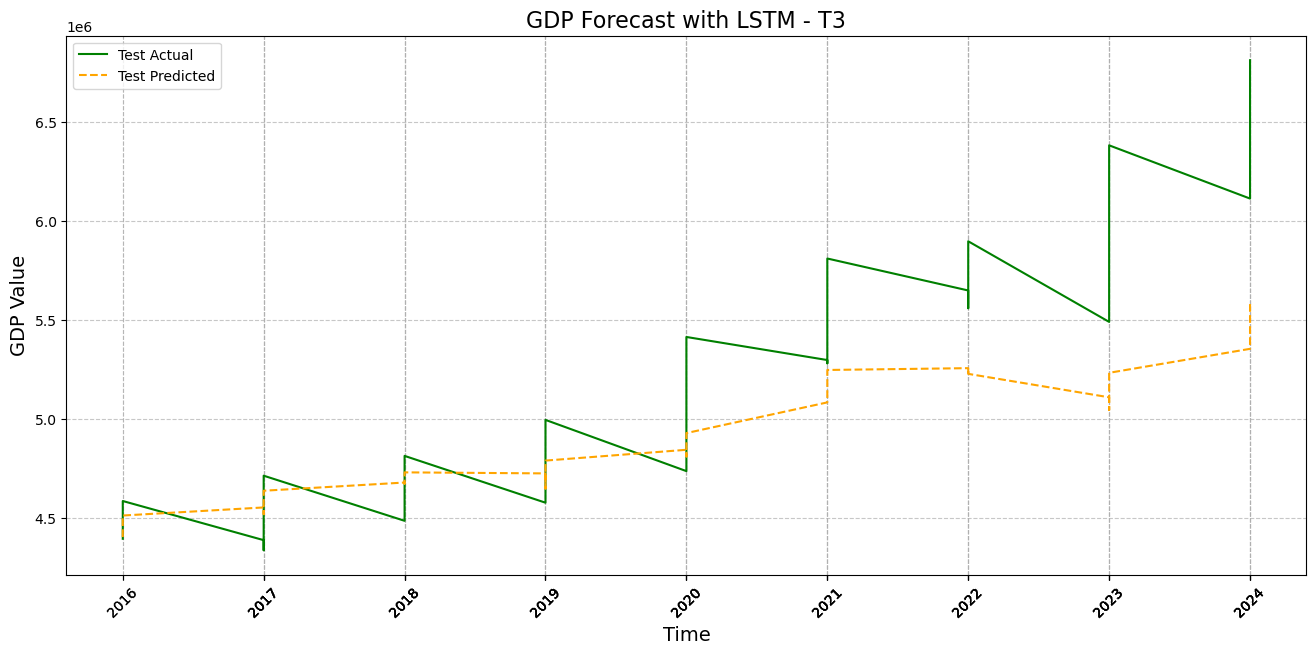

In [23]:
plot_gdp_forecast(year_df,'LSTM - T3',y_true_lstm_test,y_pred_lstm_test)

In [24]:
model.save(os.path.join(base_path,os.getenv("MIX_LSTM_T3")))